In [0]:
!unzip idd-lite_1.zip

In [0]:
!cd idd-lite_1/idd20k_lite/gtFine/val
!find . -name '*png' -exec bash -c ' mv $0 ${0/\label/image}' {} \;
!cd

In [0]:
import cv2, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [0]:
data = 'idd-lite_1/idd20k_lite/'

img_train = data + 'leftImg8bit/train/'
seg_train = data + 'gtFine/train/'

img_val = data + 'leftImg8bit/val/'
seg_val = data + 'gtFine/val/'

In [0]:
mi, ma = 0, 6
n_classes = 7

In [0]:
def getImageArr(path, width, height):
  img = cv2.imread(path, 1)
  img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
  return img

def getSegmentationArr(path, nClasses, width, height): 
  seg_labels = np.zeros((height, width, nClasses))
  img = cv2.imread(path, 1)
  img = cv2.resize(img, (width, height))
  img = img[:, :, 0]

  for c in range(nClasses):
    seg_labels[:, :, c] = (img == c).astype(int)

  return seg_labels

In [0]:
input_height, input_width = 224, 224
output_height, output_width = 224, 224

In [0]:
X_train, y_train = [], []
X_val, y_val = [], []

In [0]:
train_img = os.listdir(img_train)
train_img.sort()
train_seg = os.listdir(seg_train)
train_seg.sort()

val_img = os.listdir(img_val)
val_img.sort()
val_seg = os.listdir(seg_val)
val_seg.sort()

In [10]:
print(train_img[: 5])
print(train_seg[: 5])
print(val_img[: 5])
print(val_seg[: 5])

['0000002_image.jpg', '0000097_image.jpg', '0000192_image.jpg', '0000215_image.jpg', '0000247_image.jpg']
['0000002_label.png', '0000097_label.png', '0000192_label.png', '0000215_label.png', '0000247_label.png']
['0000000_image.jpg', '000065_image.jpg', '0001080_image.jpg', '000190_image.jpg', '0001923_image.jpg']
['0000000_label.png', '000065_label.png', '0001080_label.png', '000190_label.png', '0001923_label.png']


In [0]:
for im, seg in zip(train_img, train_seg):
  X_train.append(getImageArr(img_train + im, input_width, input_height))
  y_train.append(getSegmentationArr(seg_train + seg, n_classes, output_width, output_height)) 
  
for im, seg in zip(val_img, val_seg):
  X_val.append(getImageArr(img_val + im, input_width, input_height))
  y_val.append(getSegmentationArr(seg_val + seg, n_classes, output_width, output_height))

In [0]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val),np.array(y_val)

In [13]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(1380, 224, 224, 3) (1380, 224, 224, 7)
(204, 224, 224, 3) (204, 224, 224, 7)


In [0]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
  filters1, filters2, filters3 = filters
  bn_axis = 3

  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = Conv2D(filters1, (1, 1), name = conv_name_base + '2a')(input_tensor)
  x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2a')(x)
  x = Activation('relu')(x)

  x = Conv2D(filters2, kernel_size,
               padding = 'same', name = conv_name_base + '2b')(x)
  x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2b')(x)
  x = Activation('relu')(x)

  x = Conv2D(filters3, (1, 1), name = conv_name_base + '2c')(x)
  x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2c')(x)

  x = layers.add([x, input_tensor])
  x = Activation('relu')(x)
  
  return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides = (2, 2)):
  filters1, filters2, filters3 = filters
  bn_axis = 3

  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  x = Conv2D(filters1, (1, 1), strides = strides,
               name = conv_name_base + '2a')(input_tensor)
  x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2a')(x)
  x = Activation('relu')(x)

  x = Conv2D(filters2, kernel_size, padding = 'same',
               name = conv_name_base + '2b')(x)
  x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2b')(x)
  x = Activation('relu')(x)

  x = Conv2D(filters3, (1, 1), name = conv_name_base + '2c')(x)
  x = BatchNormalization(axis = bn_axis, name = bn_name_base + '2c')(x)

  shortcut = Conv2D(filters3, (1, 1), strides = strides,
                      name = conv_name_base + '1')(input_tensor)
  shortcut = BatchNormalization(axis = bn_axis, name = bn_name_base + '1')(shortcut)

  x = layers.add([x, shortcut])
  x = Activation('relu')(x)

  return x

In [0]:
def ResNet50(input_tensor = None, input_shape = None, pooling = None, classes = 1000):
  img_input = Input(shape = input_shape)
  bn_axis = 3

  x = Conv2D(64, (7, 7), strides = (2, 2), padding = 'same', name = 'conv1')(img_input)
  x = BatchNormalization(axis = bn_axis, name = 'bn_conv1')(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((3, 3), strides = (2, 2), padding = "same")(x)

  x = conv_block(x, 3, [64, 64, 256], stage = 2, block = 'a', strides = (1, 1))
  x = identity_block(x, 3, [64, 64, 256], stage = 2, block = 'b')
  x = identity_block(x, 3, [64, 64, 256], stage = 2, block = 'c')

  x = conv_block(x, 3, [128, 128, 512], stage = 3, block = 'a')
  x = identity_block(x, 3, [128, 128, 512], stage = 3, block = 'b')
  x = identity_block(x, 3, [128, 128, 512], stage = 3, block = 'c')
  x = identity_block(x, 3, [128, 128, 512], stage = 3, block = 'd')

  x = conv_block(x, 3, [256, 256, 1024], stage = 4, block = 'a')
  x = identity_block(x, 3, [256, 256, 1024], stage = 4, block = 'b')
  x = identity_block(x, 3, [256, 256, 1024], stage = 4, block = 'c')
  x = identity_block(x, 3, [256, 256, 1024], stage = 4, block = 'd')
  x = identity_block(x, 3, [256, 256, 1024], stage = 4, block = 'e')
  x = identity_block(x, 3, [256, 256, 1024], stage = 4, block = 'f')

  x = conv_block(x, 3, [512, 512, 2048], stage = 5, block = 'a')
  x = identity_block(x, 3, [512, 512, 2048], stage = 5, block = 'b')
  x = identity_block(x, 3, [512, 512, 2048], stage = 5, block = 'c')

  model = Model(img_input, x, name = 'resnet50')
  resnet50_weights_path = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
  model.load_weights(resnet50_weights_path)

  return model

In [0]:
def conv_block_bn(prevlayer, filters, prefix, strides = (1, 1)):
  conv = Conv2D(filters, (3, 3), padding = "same", kernel_initializer = "he_normal", strides = strides, name = prefix + "_conv")(prevlayer)
  conv = BatchNormalization(name = prefix + "_bn")(conv)
  conv = Activation('relu', name = prefix + "_activation")(conv)

  return conv

def conv_block_no_bn(prevlayer, filters, prefix, strides = (1, 1)):
  conv = Conv2D(filters, (3, 3), padding = "same", kernel_initializer = "he_normal", strides = strides, name = prefix + "_conv")(prevlayer)
  conv = Activation('relu', name = prefix + "_activation")(conv)

  return conv

In [0]:
def unet_resnet(nClasses, input_shape):
  resnet_base = ResNet50(input_shape = input_shape)

  for l in resnet_base.layers:
    l.trainable = True

  conv1 = resnet_base.get_layer("activation_1").output
  conv2 = resnet_base.get_layer("activation_10").output
  conv3 = resnet_base.get_layer("activation_22").output
  conv4 = resnet_base.get_layer("activation_40").output
  conv5 = resnet_base.get_layer("activation_49").output

  up6 = concatenate([UpSampling2D()(conv5), conv4], axis = -1)
  conv6 = conv_block_bn(up6, 256, "conv6_1")
  conv6 = conv_block_bn(conv6, 256, "conv6_2")

  up7 = concatenate([UpSampling2D()(conv6), conv3], axis = -1)
  conv7 = conv_block_bn(up7, 64, "conv7_1")
  conv7 = conv_block_bn(conv7, 64, "conv7_2")

  up8 = concatenate([UpSampling2D()(conv7), conv2], axis = -1)
  conv8 = conv_block_bn(up8, 16, "conv8_1")
  conv8 = conv_block_bn(conv8, 16, "conv8_2")

  up9 = concatenate([UpSampling2D()(conv8), conv1], axis = -1)
  conv9 = conv_block_bn(up9, 8, "conv9_1")
  conv9 = conv_block_bn(conv9, 8, "conv9_2")

  up10 = UpSampling2D()(conv9)
  conv10 = conv_block_bn(up10, nClasses, "conv10_1")
  conv10 = conv_block_bn(conv10, nClasses, "conv10_2")
  conv10 = SpatialDropout2D(0.2)(conv10)

  x = Conv2D(nClasses, kernel_size = (1, 1), strides = (1, 1), activation = "softmax", name = "prediction")(conv10)
  model = Model(resnet_base.input, x)

  return model

In [20]:
model = unet_resnet(nClasses = n_classes, input_shape = (input_width, input_height, 3))
model.summary()















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0        

In [21]:
#sgd = SGD(lr = 0.01, decay = 5 ** (-4), momentum = 0.9, nesterov = True)
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'rmsprop',
              metrics = ['accuracy'])

In [22]:
hist1 = model.fit(x = X_train, y = y_train,
                  validation_data = (X_val, y_val),
                  batch_size = 30, epochs = 30, verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1380 samples, validate on 204 samples
Epoch 1/30
1380/1380 [==============================] - 55s 40ms/step - loss: 1.5928 - acc: 0.4781 - val_loss: 1.3959 - val_acc: 0.6004
Epoch 2/30
1380/1380 [==============================] - 17s 13ms/step - loss: 1.2183 - acc: 0.6802 - val_loss: 1.0858 - val_acc: 0.7018
Epoch 3/30
1380/1380 [==============================] - 17s 13ms/step - loss: 1.0599 - acc: 0.6958 - val_loss: 1.1464 - val_acc: 0.6414
Epoch 4/30
1380/1380 [==============================] - 17s 13ms/step - loss: 0.9457 - acc: 0.6966 - val_loss: 0.8611 - val_acc: 0.7281
Epoch 5/30
1380/1380 [==============================] - 17s 13ms/step - loss: 0.8432 - acc: 0.7069 - val_loss: 1.0938 - val_acc: 0.6950
Epoch 6/30
1380/1380 [==============================] - 17s 13ms/step - loss: 0.7568 - acc: 0.7178 - val_loss: 0.6846 - val_acc: 0.7986
Epoch 7/30
1380/1380 [===================

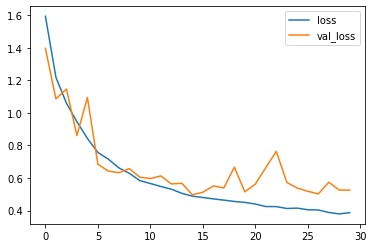

In [23]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key], label = key)
plt.legend()
plt.show()

In [24]:
y_pred = model.predict(X_val)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_val, axis=3)
print(y_testi.shape,y_predi.shape)

(204, 224, 224) (204, 224, 224)


In [0]:
def IoU(yi, y_predi):
  ## mean Intersection over Union
  ## Mean IoU = TP/(FN + TP + FP)
  IoUs = []
  Nclass = 7
  for c in range(Nclass):
    TP = np.sum((yi == c) & (y_predi == c))
    FP = np.sum((yi != c) & (y_predi == c))
    FN = np.sum((yi == c) & (y_predi != c)) 
    IoU = TP / float(TP + FP + FN)
    print('class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}'.format(c, TP, FP, FN, IoU))
    IoUs.append(IoU)

  mIoU = np.mean(IoUs)
  print('Mean IoU: {:4.3f}'.format(mIoU))

In [26]:
IoU(y_testi, y_predi)

class 00: #TP=3171257, #FP=312077, #FN=53465, IoU=0.897
class 01: #TP=     0, #FP=     6, #FN=268091, IoU=0.000
class 02: #TP=     0, #FP=     0, #FN=193778, IoU=0.000
class 03: #TP=641609, #FP=186567, #FN=235999, IoU=0.603
class 04: #TP=460076, #FP=365542, #FN=766753, IoU=0.289
class 05: #TP=2250312, #FP=831546, #FN=165952, IoU=0.693
class 06: #TP=1964203, #FP= 52709, #FN=64409, IoU=0.944
Mean IoU: 0.489


In [27]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model.save('/content/gdrive/My Drive/IDD Challenge/unet.h5')